In [1]:
from model.deeponet import *
import numpy as np
from src.collision_operator_1D import CollisionOperator1D
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [3]:
gparams = {
     'name': '1d_3_8_3_8_wo_bias',
     'seed': 0,
     'use_squeue': False,
     'gpu': 0,
     'dimension': 1,
     'data_file': 'legendre',
     'integration_order': 100,
     'model': 'deeponet',
     'branch_hidden': [100, 8, 8, 8],
     'trunk_hidden': [1, 8, 8, 8],
     'act': 'tanh',
     'd_out': 1,
     'use_bias': 'no',
     'use_gram': False,
     'batch_size': 0,
     'epochs': 100000,
     'lr': 0.001,
     'lambda': 0.0
}

In [7]:
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '1d_3_8_3_8_wo_bias',
    '1d_3_8_3_8_w_bias',
    '1d_3_8_3_8_soft_lamb01',
    '1d_3_8_3_8_hard_gram',
    '1d_3_8_3_8_hard_special'
]

In [4]:
### Data
## Load data
train_data=np.load('data/'+gparams['data_file']+'_train_data.npz')
test_data=np.load('data/'+gparams['data_file']+'_test_data.npz')

train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
if gparams['dimension']==1:
    Q = CollisionOperator1D(integration_order)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,1).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=2
elif gparams['dimension']==3:
    Q = CollisionOperator3D(integration_order)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,3).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=2

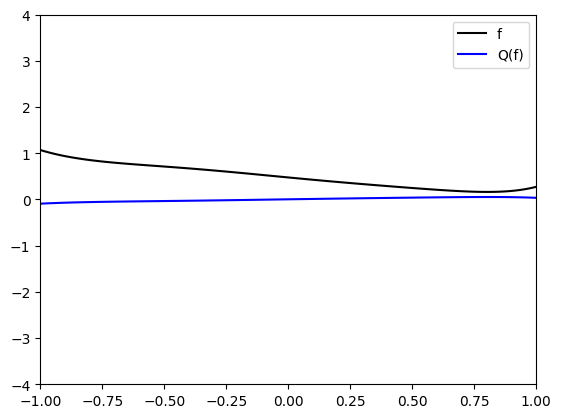

In [5]:
idx=np.random.randint(train_data_f.shape[0])
plt.plot(grid.cpu(), train_data_f[idx], 'k')
plt.plot(grid.cpu(), train_data_Q[idx], 'b')
plt.legend(["f", "Q(f)"])
plt.xlim(-1,1)
plt.ylim(-4,4)
plt.show()

In [8]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+model+'/final.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

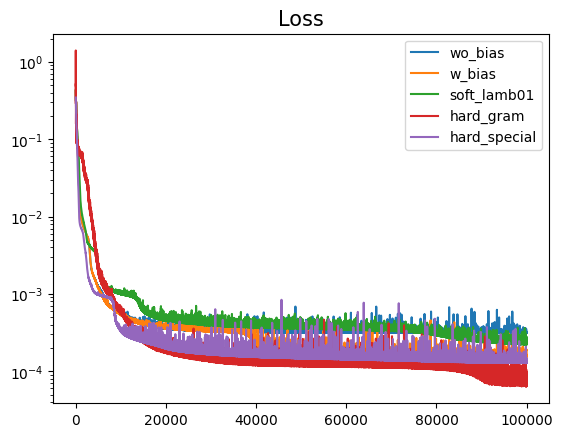

In [9]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+model+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

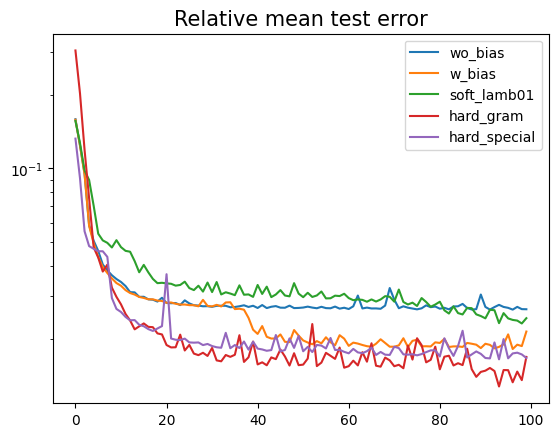

In [10]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+model+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

In [12]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

Mean_test error of total test data for wo_bias     =4.10E+01
Mean_test error of total test data for w_bias      =4.06E+01
Mean_test error of total test data for soft_lamb01 =4.95E+01
Mean_test error of total test data for hard_gram   =1.37E+01
Mean_test error of total test data for hard_special=3.34E+01


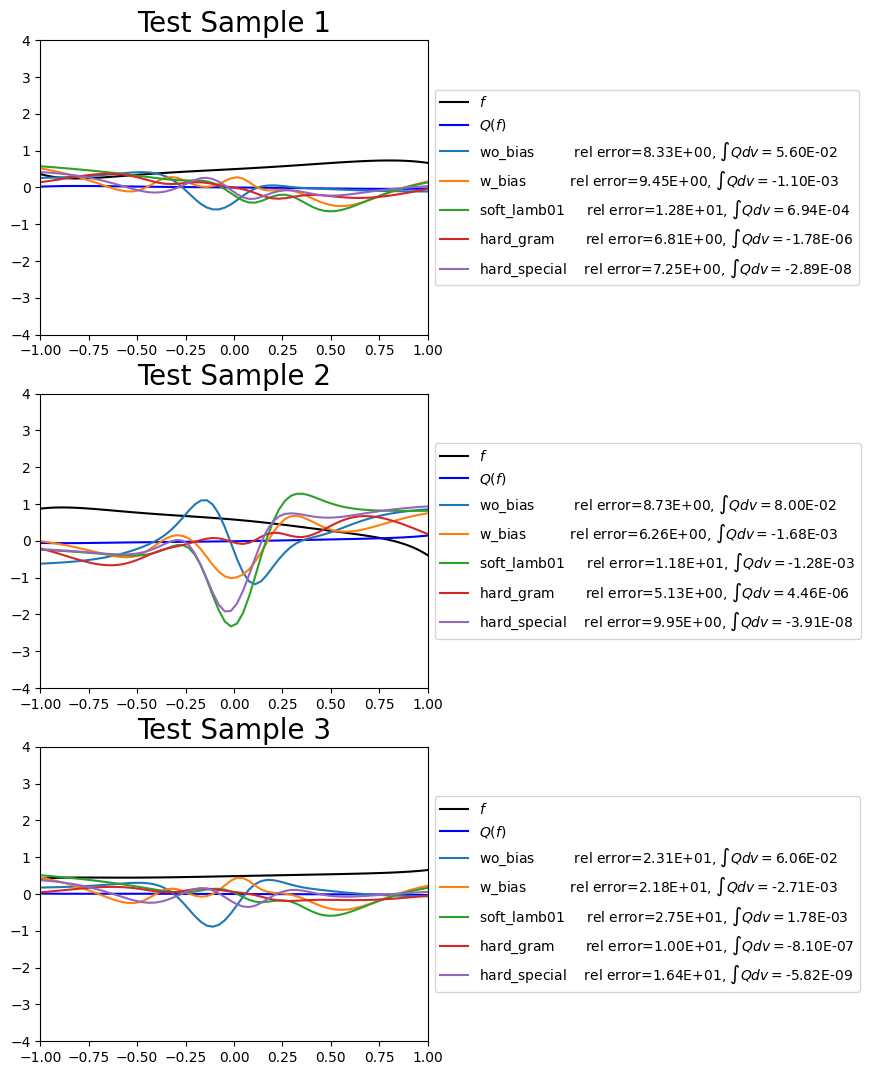

In [13]:
num_plot=3
plt.figure(figsize=(5,13))

for plot_idx in range(num_plot):
    ax=plt.subplot(num_plot,1,plot_idx+1)
    ax.set_title("Test Sample {}".format(str(plot_idx+1)), fontsize=20)
    data_idx=np.random.randint(test_data_f.shape[0])
    
    ax.plot(grid.detach().cpu(), test_data_f[data_idx], '-k', label=r'$f$')
    ax.plot(grid.detach().cpu(), test_data_Q[data_idx], 'b', markersize=3, label=r'$Q(f)$')
    ax.set_xlim(-1,1)
    ax.set_ylim(-4,4)
    for idx in range(len(models)):
        models[idx]
        prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
        ax.plot(grid.detach().cpu(), prediction, label=r"{:15s} rel error={:.2E}, $\int Q dv=${:.2E}".format(names[idx],rel_L2_error(prediction, test_data_Q[data_idx]),torch.sum(prediction*quad_w.detach().cpu())))
        if plot_idx==0:
            prediction_all=models[idx](test_data_f.cuda(), grid).squeeze().detach().cpu()
            print("Mean_test error of total test data for {:12s}={:.2E}".format(names[idx], rel_L2_error(prediction_all, test_data_Q).mean()))
#         print(names[idx])
#         print("Rel error : {:.3f}".format(rel_L2_error(prediction, test_data_Q[data_idx])))
#         print(r'$\int Q dv=${:.5f}'.format(torch.sum(prediction*quad_w.detach().cpu())))
#         print(" ")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()